## Лабораторная работа 2 "Полносвязные нейронные сети"

ФИО: Иванова Елена Владимировна

В современных фреймворках, нейронные сети конструируются в виде разнообразных слоев. Каждый слой реализует два метода forward и backward. forward предназначен для расчета выхода слоя, backward для расчета градиента. В лабораторной лаботе вам необходимо рализовать оба метода для линейного, сигмоидального и Relu.
После чего необходимо сконструировать нейронную сеть для решения задачи классификации.

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Tuple
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

### Часть 1: Линейный слой


Приведем пример вычисления градиентов для линейного слоя: $y = Wx$, $x \in \mathbb{R}^{K \times n}$, $y \in \mathbb{R}^{K \times n}$, $W \in \mathbb{R}^{n \times m}$, где $K$ — число объектов.

Рассмотрим $L$ как функцию от выходов нейронной сети: $L = L(y_{11}, y_{12}, \dots)$

$$y_{kt} = (Wx)_{kt} = \sum_{z=1}^{n} x_{kz}W_{zt}$$

$$\frac{\partial L}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial y_{kt}}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial \sum_z x_{kz}w_{zt}}{\partial x_{ij}}= \sum_{t} \frac{\partial L}{\partial y_{it}}\frac{\partial w_{jt}}{\partial x_{ij}}$$

$$\frac{\partial{L}}{\partial x} = \frac{\partial{L}}{\partial y}W^T$$

In [25]:
class Parameters:
    def __init__(self, shape: Tuple[int, int]):
        """
        Инициализирует параметры слоя:
        - `weights`: случайные веса, инициализированные небольшими значениями.
        - `grad`: массив нулей той же формы для хранения градиентов.
        """
        self.weights = np.random.randn(*shape) * 0.1
        self.grad = np.zeros_like(self.weights)

In [26]:
class Linear:
    def __init__(self, input_size: int, output_size: int):
        """
        Инициализация линейного слоя.
        """
        self.W = Parameters((output_size, input_size))  # Матрица весов W
        self.b = Parameters((output_size, 1))  # Смещения b

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Прямой проход (forward propagation):
        - X: входной тензор размером (N, input_size).
        - Возвращает: выходной тензор размером (N, output_size).
        """
        self.X = X  # Сохраняем вход для использования в backward
        return X @ self.W.weights.T + self.b.weights.T  # Вычисляем y = Wx + b

    def backward(self, dLdy: np.ndarray) -> np.ndarray:
        """
        Обратное распространение ошибки (backward propagation):
        - dLdy: градиент потерь по y (размер (N, output_size)).
        - Вычисляет и сохраняет градиенты dL/dW, dL/db.
        - Возвращает градиент dL/dX для предыдущего слоя.
        """
        N = dLdy.shape[0]  # Количество объектов
        self.W.grad = (dLdy.T @ self.X) / N  # Градиент по W
        self.b.grad = np.sum(dLdy, axis=0, keepdims=True).T / N  # Градиент по b
        return dLdy @ self.W.weights  # Градиент по входу X

In [27]:
# Тестирование работы слоя
if __name__ == "__main__":
    np.random.seed(42)  # Фиксируем сид для воспроизводимости
    layer = Linear(input_size=3, output_size=2)

    X = np.random.randn(5, 3)  # 5 объектов, 3 признака
    y = layer.forward(X)

    dLdy = np.random.randn(5, 2)  # Градиенты потерь
    dLdx = layer.backward(dLdy)

    print("Output y:\n", y)
    print("Gradient dL/dW:\n", layer.W.grad)
    print("Gradient dL/db:\n", layer.b.grad)
    print("Gradient dL/dX:\n", dLdx)

Output y:
 [[ 0.09708512  0.00338722]
 [ 0.00752138  0.04494277]
 [ 0.01441669 -0.14908639]
 [ 0.09461183  0.17893322]
 [ 0.23821753  0.3036717 ]]
Gradient dL/dW:
 [[ 0.51845998 -0.22215165  0.12091001]
 [ 0.32376224  0.06265715  0.78233529]]
Gradient dL/db:
 [[ 0.12449137]
 [-0.58224377]]
Gradient dL/dX:
 [[-0.15368037  0.03244609 -0.0795333 ]
 [-0.16979008  0.02541724  0.03413334]
 [-0.07281761  0.0088696   0.0383967 ]
 [-0.10613055  0.01812225 -0.00480449]
 [ 0.08994961 -0.02529435  0.12028595]]


In [28]:
# Создаем датасет (10 объектов, 2 признака)
X_train = torch.randn(10, 2)  # Входные данные (10 объектов, 2 признака)
y_train = torch.randint(0, 3, (10,))  # Истинные классы (0, 1 или 2)

# Определение нейросети с ReLU
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Первый (скрытый) слой
        self.relu = nn.ReLU()  # Функция активации ReLU
        self.fc2 = nn.Linear(hidden_size, output_size)  # Выходной слой

    def forward(self, x):
        x = self.fc1(x)  # Линейное преобразование fully connected - слой
        x = self.relu(x)  # Применяем ReLU
        x = self.fc2(x)  # Второе линейное преобразование
        return x  # Логиты (без softmax, т.к. CrossEntropyLoss сам его применяет) это тот х,который у

# Гиперпараметры
input_size = 2      # Количество входных признаков
hidden_size = 4     # Количество нейронов в скрытом слое
output_size = 3     # Количество классов
learning_rate = 0.1 # Скорость обучения
num_epochs = 100    # Количество эпох
batch_size = 5      # Размер батча

# Создаем модель
model = NeuralNetwork(input_size, hidden_size, output_size) # количество иксов, скрытый параметр h, игреки

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss() # используется для многоклассовой классификации
optimizer = optim.SGD(model.parameters(), lr=learning_rate) # стохастический градиентный спуск показывает оптимизатору, какие параметры он может вариировать

# Обучение с использованием батчей
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]  # Выбираем батч данных
        y_batch = y_train[i:i+batch_size]  # Выбираем соответствующие метки

        optimizer.zero_grad()  # Обнуляем градиенты

        y_pred = model(X_batch)  # Прямой проход
        loss = criterion(y_pred, y_batch)  # Вычисляем потерю

        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновляем параметры модели

    # Выводим потери каждые 10 эпох
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Эпоха {epoch}, Потеря: {loss.item():.5f}")

# Выводим итоговые веса
print("\nИтоговые веса скрытого слоя:\n", model.fc1.weight)
print("\nИтоговые веса выходного слоя:\n", model.fc2.weight)

Эпоха 0, Потеря: 1.21754
Эпоха 10, Потеря: 0.98150
Эпоха 20, Потеря: 0.88760
Эпоха 30, Потеря: 0.82656
Эпоха 40, Потеря: 0.77290
Эпоха 50, Потеря: 0.72372
Эпоха 60, Потеря: 0.68671
Эпоха 70, Потеря: 0.66315
Эпоха 80, Потеря: 0.64940
Эпоха 90, Потеря: 0.61497
Эпоха 99, Потеря: 0.53532

Итоговые веса скрытого слоя:
 Parameter containing:
tensor([[ 1.4929, -0.3374],
        [ 0.5907, -0.5391],
        [-0.0151,  0.3932],
        [ 0.9546, -1.2171]], requires_grad=True)

Итоговые веса выходного слоя:
 Parameter containing:
tensor([[ 0.6968,  0.0715,  0.4616, -0.2880],
        [ 0.8714,  0.1607, -0.2697,  0.9968],
        [-1.0239, -0.5231, -0.3855, -0.6204]], requires_grad=True)


### Часть 2, Relu (Rectified Linear Unit - активация нейронов в нейросети)

In [29]:
# Применяем ReLU отдельно
with torch.no_grad():  # Отключаем вычисление градиентов
    X_test = torch.randn(5, 2)  # Генерируем новые тестовые данные
    hidden_output = model.fc1(X_test)  # Выход скрытого слоя (до ReLU)
    relu_output = torch.relu(hidden_output)  # Применяем ReLU вручную

# Выводим результаты
print("\nВыход скрытого слоя (до ReLU):\n", hidden_output)
print("\nВыход скрытого слоя (после ReLU):\n", relu_output)


Выход скрытого слоя (до ReLU):
 tensor([[-0.8062, -2.2979,  0.5624, -4.2132],
        [ 1.0239, -0.1742, -0.8008,  0.4118],
        [-0.0272, -0.3191, -1.0506,  0.4088],
        [ 0.0728, -1.0652, -0.2967, -1.4667],
        [ 3.3730,  0.8622, -0.9273,  2.1779]])

Выход скрытого слоя (после ReLU):
 tensor([[0.0000, 0.0000, 0.5624, 0.0000],
        [1.0239, 0.0000, 0.0000, 0.4118],
        [0.0000, 0.0000, 0.0000, 0.4088],
        [0.0728, 0.0000, 0.0000, 0.0000],
        [3.3730, 0.8622, 0.0000, 2.1779]])


In [30]:
class ReLU:
    def __init__(self):
        self.X = None  # Будем сохранять X для backward

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Прямой проход (forward) ReLU: заменяет отрицательные элементы на 0.
        """
        self.X = X  # Сохраняем вход X для backward
        return np.maximum(0, X)

    def backward(self, dLdy: np.ndarray) -> np.ndarray:
        """
        Обратное распространение ошибки (backward) через ReLU.
        """
        dLdx = dLdy * (self.X > 0)  # Производная ReLU: 1 для X > 0, иначе 0
        return dLdx

In [31]:
# Создаем экземпляр ReLU
relu = ReLU()

# Входные данные
X = np.array([[-1.0, 2.0, -3.0], [4.0, -5.0, 6.0]])

# Прямой проход через ReLU
Y = relu.forward(X)
print("ReLU Forward:\n", Y)

# Градиенты от следующего слоя (единичная матрица)
dLdy = np.ones_like(X)

# Обратное распространение ошибки через ReLU
dLdx = relu.backward(dLdy)
print("ReLU Backward:\n", dLdx)

ReLU Forward:
 [[0. 2. 0.]
 [4. 0. 6.]]
ReLU Backward:
 [[0. 1. 0.]
 [1. 0. 1.]]


### Часть 3, Sigmoid - функция активации нейронной сети


In [32]:
class Sigmoid:
    def __init__(self):
        self.Y = None  # Будем сохранять выход для backward

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Прямой проход (forward): применяет сигмоиду к X.
        """
        self.Y = 1 / (1 + np.exp(-X))  # Формула сигмоиды
        return self.Y  # Возвращает преобразованные значения

    def backward(self, dLdy: np.ndarray) -> np.ndarray:
        """
        Обратное распространение (backward):
        1. Вычисляет градиент dLdx через производную сигмоиды.
        2. Возвращает dLdx.
        """
        dLdx = dLdy * self.Y * (1 - self.Y)  # Производная сигмоиды
        return dLdx

In [33]:
# Создаем экземпляр сигмоиды
sigmoid = Sigmoid()

# Входные данные
X = np.array([[-1.0, 2.0, -3.0], [4.0, -5.0, 6.0]])

# Прямой проход
Y = sigmoid.forward(X)
print("Sigmoid Forward:\n", Y)

# Градиенты от следующего слоя (единичная матрица)
dLdy = np.ones_like(X)

# Обратное распространение ошибки
dLdx = sigmoid.backward(dLdy)
print("Sigmoid Backward:\n", dLdx)

Sigmoid Forward:
 [[0.26894142 0.88079708 0.04742587]
 [0.98201379 0.00669285 0.99752738]]
Sigmoid Backward:
 [[0.19661193 0.10499359 0.04517666]
 [0.01766271 0.00664806 0.00246651]]


### Часть 4, Функция потерь

In [34]:
class NLLLoss: # (Negative Log-Likelihood Loss)
    def __init__(self):
        '''
        Применяет Softmax к входу и вычисляет отрицательное логарифмическое правдоподобие (NLL).
        '''
        self.softmax_output = None  # Будем хранить softmax(X)
        self.y = None  # Будем хранить истинные метки

    def forward(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Прямой проход (forward):
        - X: (N, C) – входные логиты, где N – число объектов, C – классы.
        - y: (N,) – истинные метки классов.

        Возвращает **скалярное значение ошибки (среднее по батчу)**.
        """
        # Применяем softmax к X
        exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))  # Вычитаем max для числовой стабильности
        self.softmax_output = exp_X / np.sum(exp_X, axis=1, keepdims=True)  # Softmax
        self.y = y  # Сохраняем метки

        # Вычисляем NLL Loss: -log(softmax[class])
        N = X.shape[0]  # Число объектов
        loss = -np.mean(np.log(self.softmax_output[np.arange(N), y]))  # Среднее по батчу
        return loss

    def backward(self) -> np.ndarray:
        """
        Обратное распространение (backward):
        Вычисляет dL/dX (градиент ошибки по входу).
        """
        N = self.softmax_output.shape[0]  # Число объектов
        dLdx = self.softmax_output.copy()  # Копируем softmax
        dLdx[np.arange(N), self.y] -= 1  # Вычитаем 1 у правильных классов
        dLdx /= N  # Усредняем по батчу

        return dLdx  # Градиент ошибки по X

In [35]:
# Тест
# Создаем экземпляр NLLLoss
loss_fn = NLLLoss()

# Входные логиты (N, C) → 3 объекта, 4 класса
X = np.array([[2.0, 1.0, 0.1, -0.5],
              [0.2, 2.5, -1.2, 0.3],
              [-1.0, 0.8, 3.0, -0.7]])

# Истинные классы (0, 1, 2)
y = np.array([0, 1, 2])

# Вычисляем loss
loss_value = loss_fn.forward(X, y)
print("NLLLoss Forward (Loss):", loss_value)

# Вычисляем градиенты
dLdx = loss_fn.backward()
print("\nNLLLoss Backward (Gradients):\n", dLdx)

NLLLoss Forward (Loss): 0.2748386987085118

NLLLoss Backward (Gradients):
 [[-0.12493918  0.07666392  0.03116923  0.01710603]
 [ 0.02704322 -0.06359937  0.00666877  0.02988738]
 [ 0.0052912   0.03200991 -0.04444349  0.00714238]]


### Часть 5, Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [36]:
eps = 10**(-6)  # Маленькое значение для численного градиента

def check_gradient(func, X):
    '''
    Проверяет корректность вычисления градиента.

    func: функция, градиент которой мы проверяем. Должна возвращать (значение функции, аналитический градиент).
    X: np.array размера (n x m), по которому вычисляем градиент.

    Возвращает: максимальное абсолютное отклонение аналитического градиента от численного.
    '''
    X = X.astype(float)  # Делаем копию, чтобы избежать ошибок с типами данных
    numerical_grad = np.zeros_like(X)  # Численный градиент
    f_x, analytical_grad = func(X)  # Вычисляем значение функции и аналитический градиент

    # Проходим по каждому элементу X
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X_plus = X.copy()
            X_minus = X.copy()

            X_plus[i, j] += eps  # Увеличиваем x_ij на epsilon
            X_minus[i, j] -= eps  # Уменьшаем x_ij на epsilon

            f_x_plus, _ = func(X_plus)  # Вычисляем f(X + eps)
            f_x_minus, _ = func(X_minus)  # Вычисляем f(X - eps)

            # Численный градиент
            numerical_grad[i, j] = (f_x_plus - f_x_minus) / (2 * eps)

    # Максимальное отклонение между численным и аналитическим градиентами
    max_deviation = np.max(np.abs(numerical_grad - analytical_grad))

    return max_deviation

In [37]:
# Проверка численного градиента для ReLU
# Используем ранее реализованный класс ReLU
class ReLU:
    def __init__(self):
        self.X = None

    def forward(self, X):
        self.X = X
        return np.maximum(0, X)

    def backward(self, dLdy):
        return dLdy * (self.X > 0)  # Производная ReLU

# Функция-обертка для численной проверки градиента
def relu_test_function(X):
    relu = ReLU()
    Y = relu.forward(X)  # Прямой проход
    dLdy = np.ones_like(Y)  # Симулируем градиенты от следующего слоя
    dLdx = relu.backward(dLdy)  # Обратное распространение
    return np.sum(Y), dLdx  # Значение функции и аналитический градиент

# Проверяем градиент
X_test = np.random.randn(3, 3)  # Случайные данные
error = check_gradient(relu_test_function, X_test)
print("Максимальное отклонение градиента ReLU:", error)

Максимальное отклонение градиента ReLU: 8.22666379463044e-11


In [38]:
# Проверка численного градиента для Sigmoid
# Используем ранее реализованный класс Sigmoid
class Sigmoid:
    def __init__(self):
        self.Y = None

    def forward(self, X):
        self.Y = 1 / (1 + np.exp(-X))  # Сигмоид
        return self.Y

    def backward(self, dLdy):
        return dLdy * self.Y * (1 - self.Y)  # Производная сигмоиды


# Функция-обертка для численной проверки градиента
def sigmoid_test_function(X):
    sigmoid = Sigmoid()
    Y = sigmoid.forward(X)  # Прямой проход
    dLdy = np.ones_like(Y)
    dLdx = sigmoid.backward(dLdy)  # Обратное распространение
    return np.sum(Y), dLdx  # Значение функции и аналитический градиент

# Проверяем градиент
X_test = np.random.randn(3, 3)  # Случайные данные
error = check_gradient(sigmoid_test_function, X_test)
print("Максимальное отклонение градиента Sigmoid:", error)

Максимальное отклонение градиента Sigmoid: 1.319365727781019e-10


In [76]:
# Проверка численного градиента для NLLLoss
# Используем ранее реализованный класс NLLLoss
class NLLLoss:
    def __init__(self):
        self.softmax_output = None
        self.y = None

    def forward(self, X, y):
        exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.softmax_output = exp_X / np.sum(exp_X, axis=1, keepdims=True)
        self.y = y
        return -np.mean(np.log(self.softmax_output[np.arange(X.shape[0]), y]))

    def backward(self):
        N = self.softmax_output.shape[0]
        dLdx = self.softmax_output.copy()
        dLdx[np.arange(N), self.y] -= 1
        dLdx /= N
        return dLdx


# Функция-обертка для численной проверки градиента
def nllloss_test_function(X):
    y_true = np.array([0, 1, 2])  # Пример истинных меток
    loss_fn = NLLLoss()
    loss = loss_fn.forward(X, y_true)  # Вычисляем loss
    dLdx = loss_fn.backward()  # Вычисляем аналитический градиент
    return loss, dLdx

# Проверяем градиент
X_test = np.random.randn(3, 3)  # 3 объекта, 3 класса (логиты)
error = check_gradient(nllloss_test_function, X_test)
print("Максимальное отклонение градиента NLLLoss:", error)

Максимальное отклонение градиента NLLLoss: 1.600208854313223e-10


### Часть 6, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе

In [77]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        """
        Создает нейросеть:
        - Один скрытый слой (Linear + ReLU)
        - Выходной слой (Linear)
        - Функция потерь: NLLLoss
        """
        self.fc1 = Linear(input_size, hidden_size)
        self.relu = ReLU()
        self.fc2 = Linear(hidden_size, output_size)
        self.loss_fn = NLLLoss()

    def forward(self, X, y=None):
        """
        Прямой проход через сеть.
        Возвращает:
        - log_probs (если y=None)
        - loss (если y передан)
        """
        self.hidden_output = self.fc1.forward(X)
        self.activated_hidden = self.relu.forward(self.hidden_output)
        logits = self.fc2.forward(self.activated_hidden)

        # Применяем log_softmax обязательно!
        self.log_probs = log_softmax(logits)

        if y is None:
            return self.log_probs
        else:
            return self.loss_fn.forward(self.log_probs, y)

    def backward(self):
        """
        Обратное распространение ошибки.
        """
        dLdy = self.loss_fn.backward()               # Градиенты от функции потерь ∂L/∂log_probs → (N, C)
        dLdx2 = self.fc2.backward(dLdy)              # Градиент по скрытому слою ∂L/∂a2
        dLdx1 = self.relu.backward(dLdx2)            # Градиент через ReLU ∂L/∂h1

#### Часть 7, Оптимизатор

В данном пунте необходимо реализовать оптимизатор, похожий по функционалу на тот, которые используется во фреймворке pytorch. Он состоит из трех методов (включая __init__) __init__ инициализирует параметры, step - обновляет веса, zero_grad - обнуляет градиенты.

In [78]:
from typing import List

class Optimizer:
    def __init__(self, parameters: List["Parameters"], lr: float):
        """
        Инициализирует оптимизатор.
        parameters: список параметров (весов) модели.
        lr: скорость обучения (learning rate).
        """
        self.parameters = parameters  # Список параметров модели
        self.lr = lr  # Скорость обучения

    def step(self) -> None:
        """
        Обновляет параметры с использованием градиентного спуска:
        W = W - lr * grad
        """
        for param in self.parameters:
            param.weights -= self.lr * param.grad  # Обновление весов

    def zero_grad(self) -> None:
        """
        Обнуляет градиенты перед следующим шагом обучения.
        """
        for param in self.parameters:
            param.grad.fill(0)  # Обнуляем градиент

### Часть 8, обучение на простых данных

Обучите архитектуру вида 4 -> 100 -> 100 -> 3:
* Linear(4, 100)
* Relu()
* Linear(100, 100)
* Relu()
* Linear(100, 3)

* В качестве функции потерь используйте NLLLoss.

* Для обноваления весов используйте написанный вами оптимизатор.
* Нарисуйте график сходимости (величина NLL после каждого обновления).



In [44]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [79]:
# Загружаем датасет
iris = load_iris(as_frame=True)

# Создаем DataFrame
df = pd.DataFrame(iris["data"], columns=iris["feature_names"])
df["target"] = iris["target"]  # Добавляем столбец с метками классов

# Выводим таблицу
print(df.head(10))  # Вывод первых 5 строк

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   
5                5.4               3.9                1.7               0.4   
6                4.6               3.4                1.4               0.3   
7                5.0               3.4                1.5               0.2   
8                4.4               2.9                1.4               0.2   
9                4.9               3.1                1.5               0.1   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  
5       0  
6       0  
7       0  
8       0  
9       0 

In [80]:
# Предобработка
X = iris["data"].values
y = iris["target"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [81]:
# Сначала стратифицированное разбиение (с random_state)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

In [89]:
def log_softmax(x):
    x_shifted = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x_shifted)
    softmax = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    return np.log(softmax + 1e-9)

In [97]:
class DeepNeuralNetwork:
    def __init__(self):
        self.fc1 = Linear(4, 100)
        self.relu1 = ReLU()
        self.fc2 = Linear(100, 100)
        self.relu2 = ReLU()
        self.fc3 = Linear(100, 3)
        self.loss_fn = NLLLoss()

    def forward(self, X, y=None):
        self.h1 = self.relu1.forward(self.fc1.forward(X))
        self.h2 = self.relu2.forward(self.fc2.forward(self.h1))
        logits = self.fc3.forward(self.h2)
        self.out = log_softmax(logits)
        if y is None:
            return self.out
        else:
            return self.loss_fn.forward(self.out, y)

    def backward(self):
        dLdy = self.loss_fn.backward()
        print("dLdy max:", np.max(dLdy))  # Отладка: должен быть > 0

        dLdx3 = self.fc3.backward(dLdy)
        print("fc3.W.grad max:", np.max(self.fc3.W.grad))

        dLdx2 = self.relu2.backward(dLdx3)
        dLdx1 = self.fc2.backward(dLdx2)
        print("fc2.W.grad max:", np.max(self.fc2.W.grad))

        dLdx0 = self.relu1.backward(dLdx1)
        _ = self.fc1.backward(dLdx0)
        print("fc1.W.grad max:", np.max(self.fc1.W.grad))

    def parameters(self) -> List[Parameters]:
        params = []
        for layer in [self.fc1, self.fc2, self.fc3]:
            if isinstance(layer, Linear):
                params.append(layer.W)
                params.append(layer.b)
        return params

In [102]:
# Инициализация модели, её параметров и оптимизатора
input_size = X_train.shape[1]
hidden_size = 100
output_size = np.unique(y_train).shape[0]

model = DeepNeuralNetwork()
criterion = NLLLoss()
optimizer = Optimizer(model.parameters(), lr=0.1)

In [103]:
num_epochs = 2500
batch_size = 64

loss_history = []
num_samples = X_train.shape[0]

for epoch in range(num_epochs):
    indices = np.random.permutation(num_samples)
    epoch_loss = 0
    num_batches = 0

    for start in range(0, num_samples, batch_size):
        optimizer.zero_grad()  # Обнуляем градиенты всех параметров

        batch_indices = indices[start:start + batch_size]
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]

        # Прямой проход
        logits = model.forward(X_batch)

        # Вычисление функции потерь
        loss = criterion.forward(logits, y_batch)
        epoch_loss += loss
        num_batches += 1

        # Обратное распространение fcX возвращает градиент по входу, который идёт дальше по цепочке
        dLdz = criterion.backward()            # ∂L/∂z (logits)
        dh2 = model.fc3.backward(dLdz)         # ∂L/∂h2
        da2 = model.relu2.backward(dh2)        # ∂L/∂a2
        dh1 = model.fc2.backward(da2)          # ∂L/∂h1
        da1 = model.relu1.backward(dh1)        # ∂L/∂a1
        _    = model.fc1.backward(da1)         # ∂L/∂x

        # Шаг оптимизатора
        optimizer.step()

    # Логгирование
    if epoch % 10 == 0:
        avg_epoch_loss = epoch_loss / num_batches
        loss_history.append(avg_epoch_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Avg Loss: {avg_epoch_loss:.4f}")

Epoch 0, Avg Loss: 1.1496
Epoch 100, Avg Loss: 1.0111
Epoch 200, Avg Loss: 0.8891
Epoch 300, Avg Loss: 0.7723
Epoch 400, Avg Loss: 0.6752
Epoch 500, Avg Loss: 0.5890
Epoch 600, Avg Loss: 0.5195
Epoch 700, Avg Loss: 0.4667
Epoch 800, Avg Loss: 0.4206
Epoch 900, Avg Loss: 0.3914
Epoch 1000, Avg Loss: 0.3543
Epoch 1100, Avg Loss: 0.3330
Epoch 1200, Avg Loss: 0.3082
Epoch 1300, Avg Loss: 0.2932
Epoch 1400, Avg Loss: 0.2721
Epoch 1500, Avg Loss: 0.2549
Epoch 1600, Avg Loss: 0.2433
Epoch 1700, Avg Loss: 0.2335
Epoch 1800, Avg Loss: 0.2192
Epoch 1900, Avg Loss: 0.2089
Epoch 2000, Avg Loss: 0.2018
Epoch 2100, Avg Loss: 0.1918
Epoch 2200, Avg Loss: 0.1794
Epoch 2300, Avg Loss: 0.1729
Epoch 2400, Avg Loss: 0.1663


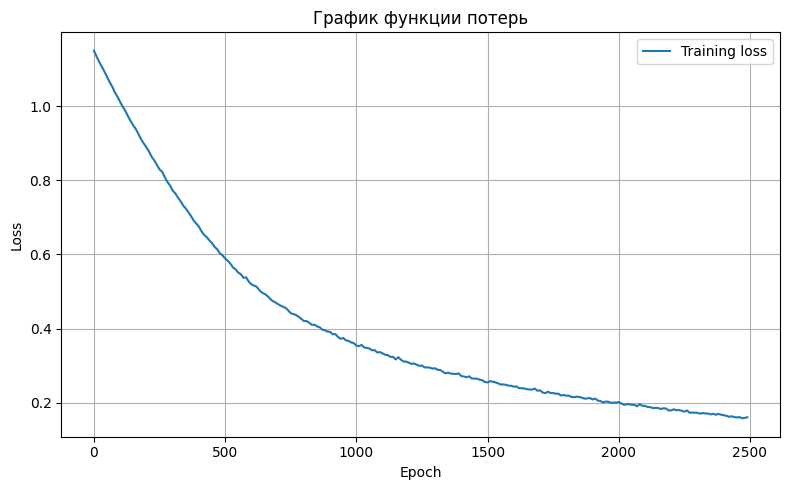

In [104]:
plt.figure(figsize=(8, 5))
plt.plot(range(0, num_epochs, 10), loss_history, label='Training loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("График функции потерь")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [105]:
iris["target"]

,target
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2
